### July 14th Riddler Classic: SquishyBall Playoff Strategy 
***

The July 14th Riddler Classic from [FiveThirtyEight](https://fivethirtyeight.com/features/can-you-eat-more-pizza-than-your-siblings/) is as follows: 

> Congratulations! The Acme Axegrinders, which you own, are the regular season champions of the National Squishyball League (NSL). Your team will now play a championship series against the Boondocks Barbarians, which had the second-best regular season record. You feel good about Acme’s chances in the series because Acme won exactly 60 percent of the hundreds of games it played against Boondocks this season. (The NSL has an incredibly long regular season.) The NSL has two special rules for the playoffs:

> 1. The owner of the top-seeded team (i.e., you) gets to select the length of the championship series in advance of the first game, so you could decide to play a single game, a best two out of three series, a three out of five series, etc., all the way up to a 50 out of 99 series $~~~~~~~~~~~~~~~~~~~$.

> 2. The owner of the winning team gets \$1 million minus \$10,000 for each of the victories required to win the series, regardless of how many games the series lasts in total. Thus, if the top-seeded team’s owner selects a single-game championship, the winning owner will collect \$990,000. If he or she selects a 4 out of 7 series, the winning team’s owner will collect \$960,000. The owner of the losing team gets nothing.

> Since Acme has a 60 percent chance of winning any individual game against Boondocks, Rule 1 encourages you to opt for a very long series to improve Acme’s chances of winning the series. But Rule 2 means that a long series will mean less winnings for you if Acme does take the series.

> How long a series should you select in order to maximize your expected winnings? And how much money do you expect to win?

First, let's state our assumptions.  

1. We assume that we're playing from the perspective of Acme.
2. Motivated by the last sentence in Rule 2, we assume that _losing_ the series to the Boondocks does not cost us anything.  That is, there is no negative payoff if we win, say, 3 games in a 7 game series but lose the series overall.   

Some notation: Let $N$ be the number of games required to win a particular series.  Then an $N$-win series is the first to $N$ out of a possible $2N-1$ games.  

Our strategy will be to compute the **expected payoff** of each $N$-win series for $N=1,2, \ldots 50$ and choose the value of $N$ with the largest expected payoff. 

Before jumping into fun probability-by-hand computations, let's see if we can get an idea of the optimal series length using Monte Carlo simulation.  The following code estimates the expected payoff for each series length by simulating 1M independent series and averaging the realized payoffs.    

In [3]:
def series_sim(N, M):
    # We draw M samples from Bin(2N-1, p) to simulate the number of wins in a  
    # 2N-1 length series where the probability of and individual win is p=0.6 
    wins = np.random.binomial(2*N-1, 0.6, M)
    
    # We win the series if wins >= N and return N as the number of wins
    # We lose the series if wins < N and return 0 as the number of wins 
    return map(lambda w: N if w >= N else 0, wins)

def payoff_sim(N, M):
    # We simulate M samples of an N-win series and compute the expected payoff
    expected_payoff = np.sum(map(lambda w: 1000000 - 10000*w if w > 0 else 0.0, series_sim(N, M))) / M 
    return expected_payoff 

def tournaments_sim(M=10000):
    # Run the simulation with M independent samples and compute expected 
    # payoffs for series of lengths N=1, 2, ..., 50
    payoffs = np.array([payoff_sim(N, M) for N in xrange(1,51)])
    return payoffs

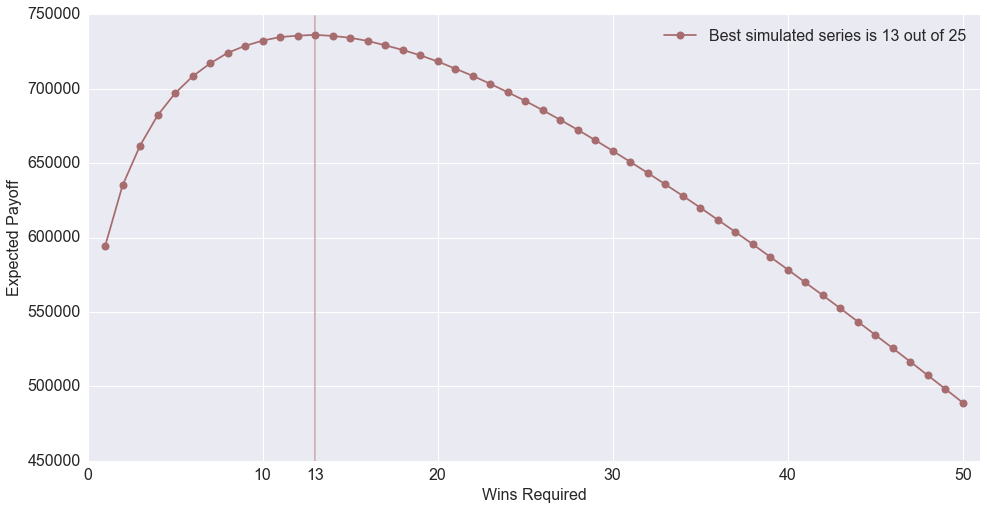

In [53]:
mc_payoffs = tournaments_sim(M=5000000)
plot_tournaments(mc_payoffs = mc_payoffs)

According to the simulation the series with the greatest expected payoff corresponds to $N=13$, meaning that the series is **first to 13 out of 25** games.  

Let's see if we can work out the exact expectation and confirm our simulation results. 

In general, the probability of winning the series on the $K^\textrm{th}$ game (where $K \geq N)$ is equal to the probability that we have won $N-1$ out of the first $K-1$ games and then win the $K^\textrm{th}$ game to win the series.  Let $P(K,N)$ be the probability that we win the $N$-win series on the $K^\textrm{th}$ game.

The probability that we randomly generate any particular $K-1$ length series with exactly $N-1$ wins is 

$
(0.6)^{N-1}(0.4)^{K-N}
$

Since there are ${{N-1}\choose{K-1}}$ ways that we can generate exactly $N-1$ wins, the probability of winning exactly $N-1$ of $K-1$ games is 

$
{{N-1}\choose{K-1}} (0.6)^{N-1}(0.4)^{K-N}
$

Finally, multiplying by the probability that we win the $K^\textrm{th}$ game gives 

$P(K,N) = {{N-1}\choose{K-1}} (0.6)^{N-1}(0.4)^{K-N} \times (0.6) = {{N-1}\choose{K-1}} (0.6)^{N}(0.4)^{K-N}$

Now we simply sum up the weighted payoffs for ending the series on games $K=N, \ldots, 2N-1$.  We have 

$$
\mathbb{E}[\texttt{PayOff}] = \sum_{K=N}^{2N-1} P(K,N)\left[$1,000,000 + N\times-$10,000\right]
$$

Notice that despite the fact that $P(K,N)$ is not a distribution, this is a valid expectation since the probabilities for events not accounted for (e.g. losing the series on the $K^\textrm{th}$ game) are associated with payoffs of zero. 

The following code computes the expected payoff for each $N$-win series for $N=1, 2, \ldots, 50$. 

In [5]:
from scipy.special import binom 

def P(K, N):
    # Function to compute the probability of winning an N-win 
    # series on the Kth game 
    assert(K >= N)
    return binom(K-1, N-1) * (0.6)**N * (0.4)**(K-N)

def expected_payoff(N):
    # Function to compute he expected payoff of winning an 
    # N-win series. 
    return np.sum([P(K, N)*(1e6 - N*1e4) for K in xrange(N,2*N)])

def tournaments_expected():
    # Function to compute expected payoff over series requiring 
    # 1, 2, ..., N  wins
    return [expected_payoff(N) for N in xrange(1,51)]

Running the code and plotting the results gives 

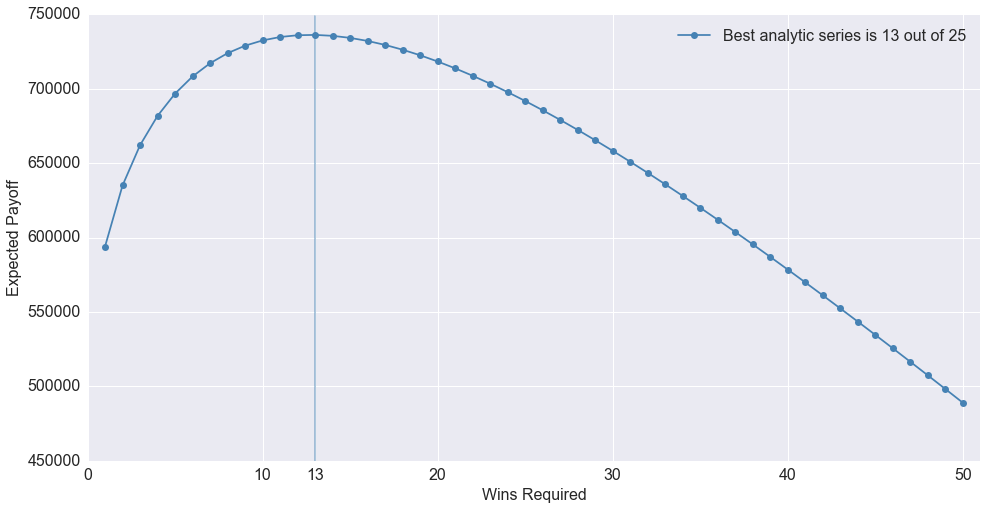

In [52]:
expected_payoffs = tournaments_expected()
plot_tournaments(expected_payoffs = expected_payoffs)

It appears that our analytic computation of the expected payoff agrees well with our simulated results.  We therefore conclude that the optimal choice of playoff series length is **best of 13 out of 25 games**.  The corresponding element of the $\texttt{expected_payoffs}$ vector is the maximum expected payoff. 

In [7]:
print "maximum expected payoff = ", expected_payoffs[13-1]

maximum expected payoff =  736222.040991


From this we see that the expected payoff in choosing to play a best of 25 series is approximately ${\bf \$736,222}$.  

As a sanity check, it's nice to overlay the analytic results with the simulated results.  We have 

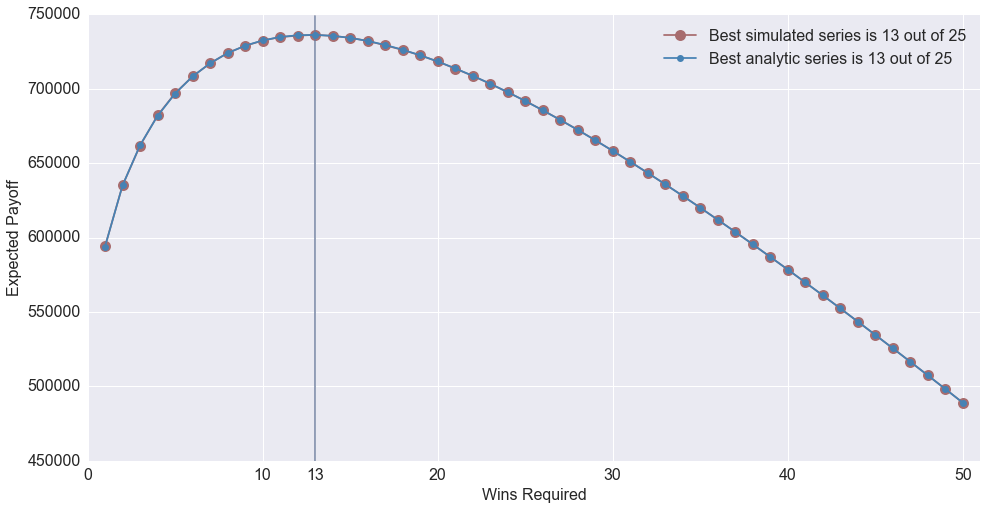

In [51]:
plot_tournaments(mc_payoffs = mc_payoffs, expected_payoffs = expected_payoffs)

If you squint you can see a few points where the simulated results disagree slightly with the analytic results, owing to sampling error in the Monte Carlo simulation.  

<br><br><br><br>
<br><br><br><br>

### Helper Functions
***

In [50]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

mycolors = {"blue": "steelblue", "red": "#a76c6e", "green": "#6a9373"}

def plot_tournaments(mc_payoffs=None, expected_payoffs=None):
    
    if (mc_payoffs is None) and (expected_payoffs is None): 
        print "You need to give me some data, Dude."
        return
    
    fig = plt.figure(figsize=(16,8))
    ax = fig.add_subplot(111)
    
    
    if mc_payoffs is not None:
        best_mc = np.argmax(mc_payoffs) + 1 
        mc_report = "Best simulated series is " + str(best_mc) + " out of " + str(2*best_mc-1)
        markersize = 11 if expected_payoffs is not None else 8 
        plt.plot([ii+1 for ii in xrange(50)], mc_payoffs, color=mycolors["red"], marker="o", markersize=markersize, label=mc_report)
        plt.plot([best_mc, best_mc], [450000,749000], color=mycolors["red"], linestyle="-", alpha=0.5)
        extratick = [best_mc]

        
    if expected_payoffs:
        best_expected = np.argmax(expected_payoffs) + 1 
        expected_report = "Best analytic series is " + str(best_expected) + " out of " + str(2*best_expected-1)
        plt.plot([ii+1 for ii in xrange(50)], expected_payoffs, color=mycolors["blue"], marker="o", label=expected_report)
        plt.plot([best_expected, best_expected], [450000,749000], color=mycolors["blue"], linestyle="-", alpha=0.5)
        extratick = [best_expected]
        
    plt.xticks(list(plt.xticks()[0]) + extratick)
    
    plt.xlim([0, 51])

    plt.legend(loc="upper right", prop={'size':16})
        
    plt.xlabel("Wins Required", fontsize=16)
    plt.ylabel("Expected Payoff", fontsize=16)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.tick_params(axis='both', which='minor', labelsize=16)
    